## Author
- Selim Lakhdar
    - selim.lakhdar@gmail.com
    - selim.lakhdar.etu@univ-lille.fr
------------------------------

## Import Libraries

In [66]:
from bs4 import BeautifulSoup,SoupStrainer

import os
import time
import re
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

random_state = 42

In [2]:
def data_loader():
    l_topics, l_title, l_body = [], [], []

    for i in range(22):
        # 17 file contains error
        if i == 17:
            continue

        file_name = f'../2/data/reuteurs21578/reut2-{i:03d}.sgm'
        print(file_name)
        f = open(file_name, 'r')
        data = f.read()

        soup = BeautifulSoup(data, "html.parser")
        contents = soup.findAll('reuters')

        topic_err, title_err, body_err = 0, 0, 0

        for content in contents:
            # topics
            try:
                topics = content.findAll("topics")[0].findAll("d")
                tmp_topics = []
                for topic in topics:
                    tmp_topics += [topic.text]

                if len(tmp_topics) == 0:
                    topic_err += 1
                    l_topics += [['Unkown']]
                else:
                    l_topics += [tmp_topics]
            except:
                topic_err += 1
                l_topics += ['Unkown']
            # title
            try:
                title = content.findAll("title")[0].text
                l_title += [title]
            except:
                title_err += 1
                l_title += ['Unkown']
            # body
            try:        
                body = content.findAll("body")[0].text
                l_body += [body]
            except:
                body_err += 1
                l_body += ['Unkown']

        print(i, "l_topics:", len(l_topics), "topic_err:", topic_err)
        print(i, "l_title:", len(l_title), "title_err:", title_err)
        print(i, "l_body:", len(l_body), "body_err:", body_err)
        print("===================================")

    reuteurs_df = pd.DataFrame()
    reuteurs_df['topics'] = l_topics
    reuteurs_df['title'] = l_title
    reuteurs_df['body'] = l_body
    return reuteurs_df

In [3]:
reuteurs_df = data_loader()
reuteurs_df

../2/data/reuteurs21578/reut2-000.sgm
0 l_topics: 1000 topic_err: 488
0 l_title: 1000 title_err: 15
0 l_body: 1000 body_err: 75
../2/data/reuteurs21578/reut2-001.sgm
1 l_topics: 2000 topic_err: 476
1 l_title: 2000 title_err: 5
1 l_body: 2000 body_err: 70
../2/data/reuteurs21578/reut2-002.sgm
2 l_topics: 3000 topic_err: 436
2 l_title: 3000 title_err: 3
2 l_body: 3000 body_err: 94
../2/data/reuteurs21578/reut2-003.sgm
3 l_topics: 4000 topic_err: 409
3 l_title: 4000 title_err: 1
3 l_body: 4000 body_err: 74
../2/data/reuteurs21578/reut2-004.sgm
4 l_topics: 5000 topic_err: 431
4 l_title: 5000 title_err: 5
4 l_body: 5000 body_err: 103
../2/data/reuteurs21578/reut2-005.sgm
5 l_topics: 6000 topic_err: 387
5 l_title: 6000 title_err: 3
5 l_body: 6000 body_err: 76
../2/data/reuteurs21578/reut2-006.sgm
6 l_topics: 7000 topic_err: 382
6 l_title: 7000 title_err: 2
6 l_body: 7000 body_err: 79
../2/data/reuteurs21578/reut2-007.sgm
7 l_topics: 8000 topic_err: 412
7 l_title: 8000 title_err: 8
7 l_body: 

,topics,title,body
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...
1,[Unkown],STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...
2,[Unkown],TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...
3,[Unkown],TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...
4,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
...,...,...,...
20573,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan\nshipping ...
20574,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is\ngrowi...
20575,[gold],SIX KILLED IN SOUTH AFRICAN GOLD MINE ACCIDENT,Six black miners have been killed\nand two inj...
20576,[Unkown],PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES,The prospect of a dominant alliance of\nsocial...


In [4]:
reuteurs_df

,topics,title,body
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...
1,[Unkown],STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...
2,[Unkown],TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...
3,[Unkown],TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...
4,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
...,...,...,...
20573,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan\nshipping ...
20574,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is\ngrowi...
20575,[gold],SIX KILLED IN SOUTH AFRICAN GOLD MINE ACCIDENT,Six black miners have been killed\nand two inj...
20576,[Unkown],PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES,The prospect of a dominant alliance of\nsocial...


In [5]:
def preprocess_text_clean(msg):
    msg = msg.replace('\n', ' ')
    msg = msg.replace('\r', ' ')
    msg = msg.replace('Reuter\x03', ' ')
    msg = msg.replace('REUTER\x03', ' ')
    msg = msg.replace('Reuter \x03', ' ')
    
    # remove <tag>
    #msg = re.sub(r'<(?<=<).*?(?=>)>', ' ', msg)
    msg = msg.replace('<', ' ')
    msg = msg.replace('>', ' ')
    
    # remove  -
    msg = msg.replace(' - ', ' ')
    
    # reformat  ,
    msg = msg.replace(' , ', ', ')
    
    # join tokens
    msg = ' '.join(msg.split())
    
    return msg

In [6]:
reuteurs_df['body'] = reuteurs_df['body'].map(preprocess_text_clean)

In [7]:
sentence = reuteurs_df.iloc[0, 2]
sentence

'Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are

In [8]:
full_text = reuteurs_df["body"][:2000].str.cat(sep=' #MLNLP# ')

In [9]:
sentences = []
sentences.append(preprocess_text_clean(full_text))
vocab = list(set((" ".join(sentences)).split()))

## Co-occurence

In [10]:
w = []
window_size = 2
for i in sentences:
    i = i.split(' ')  # if i is list
    for k in range(len(i)-window_size+1):
        if i[k] != "#MLNLP#":

            le_min = max(0, k-window_size)
            le_max = min(len(i), k+window_size+1)
            l = k
            while l >= le_min and i[l] != "#MLNLP#":
                if l <= len(i)-1 and k != l:
                    w.append([i[k], i[l]])
                l -= 1
            l = k
            while l < le_max and i[l] != "#MLNLP#":
                if l <= len(i)-1 and k != l:
                    w.append([i[k], i[l]])
                l += 1

In [11]:
w[:5]

[['Showers', 'continued'],
 ['Showers', 'throughout'],
 ['continued', 'Showers'],
 ['continued', 'throughout'],
 ['continued', 'the']]

In [12]:
# Add reverse
w1 = [x[::-1] for x in w]
w.extend(w1)

In [13]:
a = np.zeros((len(vocab), len(vocab)))
df = pd.DataFrame(a, index=vocab, columns=vocab)
for i in w:
    df.at[i[0], i[1]] += 1
df

,exceptional,consecutive,Salaam,Eurosterling,commission,"Sy,",91.8,transports,pre-clinical,Malcolm,...,recipients.,strategy,Authorities,Depository,pace.,Irvine,Israeli,About,carrier,qualities
exceptional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
consecutive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Salaam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eurosterling,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
commission,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Irvine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Israeli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
About,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
carrier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarité

In [14]:
def cosine_similarity(w1, w2, df):
    oc_w1 = df[w1].to_numpy()
    oc_w2 = df[w2].to_numpy()

    cosine_up = np.sum(oc_w1*oc_w2)
    try:
        cosine_down = np.sqrt(np.sum(oc_w1**2)) * np.sqrt(np.sum(oc_w2**2))
    except:
        return 0

    return cosine_up/cosine_down

In [15]:
def cosine_similarity_space(word):
    cos_sim = {}
    for w in vocab:
        res = cosine_similarity(w, word, df)
        cos_sim[w] = res
    return cos_sim

In [16]:
def dic_first_10(dic):
    d = dict(sorted(dic.items(), reverse=True, key=lambda item: item[1]))
    return dict(itertools.islice(d.items(), 10))

In [17]:
cos_sim_fr = cosine_similarity_space('France')

/tmp/ipykernel_412081/1620217652.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return cosine_up/cosine_down


In [18]:
def plot_similarity(dic):
    plt.figure(figsize=(5, 5))
    sns.barplot(y=list(dic.keys()),
                x=list(dic.values()), palette='Reds')
    plt.xlabel('similarity')
    plt.ylabel('words')
    plt.show()

In [19]:
sim_france = dic_first_10(cos_sim_fr)
sim_france

{'America': 0.7561756970268559,
 'England': 0.7557258702888306,
 'Japan': 0.7477032145117014,
 'Commerice.': 0.6822882392210129,
 'Japan,': 0.6715237678383074,
 'Switzerland': 0.6687762430634061,
 'Canada': 0.6529998061608357,
 'distribution': 0.637435735027564,
 'capital': 0.6349930119976075,
 'Ceylon,': 0.6344590721049271}

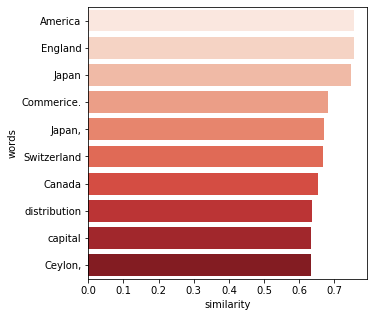

In [20]:
plot_similarity(sim_france)

/tmp/ipykernel_412081/1620217652.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return cosine_up/cosine_down


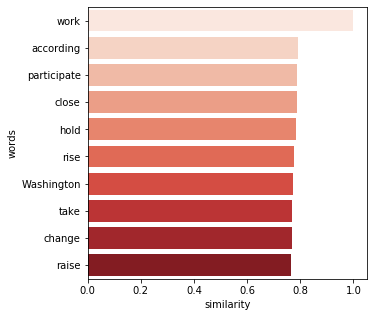

In [21]:
cos_sim_work = cosine_similarity_space('work')
dic_work = dic_first_10(cos_sim_work)
plot_similarity(dic_work)

/tmp/ipykernel_412081/1620217652.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return cosine_up/cosine_down


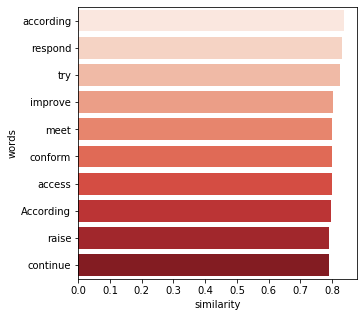

In [22]:
cos_sim_travel = cosine_similarity_space('travel')
dic_travel = dic_first_10(cos_sim_travel)
plot_similarity(dic_travel)

## PPMI

In [23]:
total_counts = df.sum(axis=1).sum(axis=0)

def ppmi(w1, w2, df, debug=False):
    sum_oc_w1 = df[w1].to_numpy().sum()
    sum_oc_w2 = df[w2].to_numpy().sum()
    w1_w2_cooc = df[w1][w2]
    
    if debug:
        print("ppmi:", 'sum_oc_w1:', sum_oc_w1, 'sum_oc_w2:', sum_oc_w2, 'w1_w2_cooc:', w1_w2_cooc)

    P_w1_w2 = w1_w2_cooc / total_counts
    P_w1 = sum_oc_w1 / total_counts
    P_w2 = sum_oc_w2 / total_counts
    
    if debug:
        print("ppmi:", 'P_w1_w2:', P_w1_w2, 'P_w1:', P_w1, 'P_w2:', P_w2)
    
    ppmi = np.log2(P_w1_w2 / (P_w1 * P_w2))
    
    return np.max([ppmi, 0])

In [30]:
ppmi('France', 'Paris', df, debug=True)

ppmi: sum_oc_w1: 208.0 sum_oc_w2: 80.0 w1_w2_cooc: 0.0
ppmi: P_w1_w2: 0.0 P_w1: 0.00010886495720769759 P_w2: 4.1871137387576e-05


/tmp/ipykernel_412081/225365919.py:18: RuntimeWarning: divide by zero encountered in log2
  ppmi = np.log2(P_w1_w2 / (P_w1 * P_w2))


0.0

In [31]:
ppmi('continued', 'to', df, debug=True)

ppmi: sum_oc_w1: 398.0 sum_oc_w2: 51844.0 w1_w2_cooc: 44.0
ppmi: P_w1_w2: 2.3029125563166797e-05 P_w1: 0.00020830890850319058 P_w2: 0.027134590584018625


2.026530046899949

In [32]:
def ppmi_all_wspace(word):
    ppmi_space = {}
    for w in vocab:
        res = ppmi(w, word, df)
        ppmi_space[w] = res
    return ppmi_space

In [33]:
fra = ppmi_all_wspace('Paris')

/tmp/ipykernel_412081/225365919.py:18: RuntimeWarning: divide by zero encountered in log2
  ppmi = np.log2(P_w1_w2 / (P_w1 * P_w2))
/tmp/ipykernel_412081/225365919.py:18: RuntimeWarning: invalid value encountered in double_scalars
  ppmi = np.log2(P_w1_w2 / (P_w1 * P_w2))


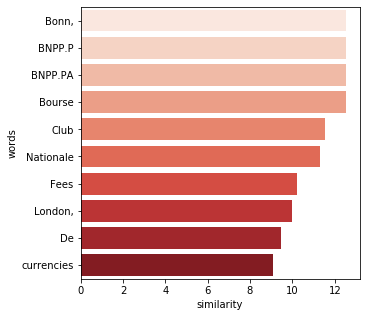

In [34]:
f_ten = dic_first_10(fra)
plot_similarity(f_ten)

# Embeddings

In [35]:
import gensim.models.keyedvectors as word2vec

model = word2vec.KeyedVectors.load_word2vec_format("/media/lakhdar/SS/model.bin", binary=True)

In [36]:
model.similarity('paris', 'france')

0.79887044

In [37]:
def word2vec(word):
    sim = {}
    for w in vocab:
        try:
            res = model.similarity(word, w)
            sim[w] = res
        except:
            sim[w] = 0
    return sim

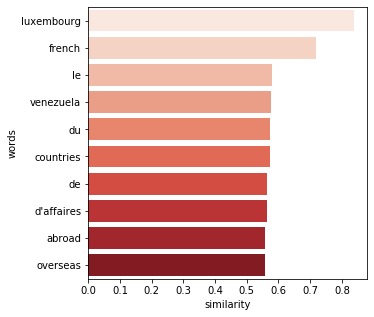

In [38]:
france_similarities = word2vec('france')
w2v_france_sim = dic_first_10(france_similarities)
plot_similarity(w2v_france_sim)

## Document classification

In [73]:
best_topics = ['earn', 'acq', 'money-fx', 'grain', 'crude', 'trade']

l = []
for index, row in reuteurs_df.iterrows():
    if len(row['topics']) == 1:
        for t in row['topics']:
            if t in best_topics:
                # from array to elem
                row[0] = row[0][0]
                l += [row]
                
top_topics_reuteurs_df = pd.DataFrame(l)
top_topics_reuteurs_df

,topics,title,body,1topic
8,earn,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,18
9,acq,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,1
10,earn,COBANCO INC <CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,858,0...",18
12,earn,AM INTERNATIONAL INC <AM> 2ND QTR JAN 31,Oper shr loss two cts vs profit seven cts Oper...,18
13,earn,BROWN-FORMAN INC <BFD> 4TH QTR NET,Shr one dlr vs 73 cts Net 12.6 mln vs 15.8 mln...,18
...,...,...,...,...
20554,acq,CABLE AND WIRELESS TO MERGE TWO H.K. UNITS INT...,Unkown,1
20555,money-fx,BALLADUR INSISTS ON MAINTENANCE OF LOUVRE ACCORDS,French Finance Minister Edouard Balladur issue...,44
20561,trade,PHILIPPINE TRADE GAP WIDENS IN JANUARY-AUGUST,The Philippines' trade deficit widened to 542 ...,74
20567,crude,"IRAN, SOVIET UNION TO SWAP CRUDE, REFINED PROD...",The Soviet Union has agreed to supply Iran wit...,15


In [75]:
bodies = top_topics_reuteurs_df['body']
docs_vectors = pd.DataFrame() 
stop_words = spacy.lang.en.stop_words.STOP_WORDS

for body in bodies:  
    preprocessed_body = preprocess_text_clean(body)
    temp = pd.DataFrame()  

    for word in body.split(' '):
        # if word is not present in stopwords then (try)
        if word not in stop_words:
            try:
                # try to get the vector from model (embeddingd) is it exists
                word_vec = model[word]
                temp = temp.append(pd.Series(word_vec), ignore_index=True)
            except:
                # if it's not than just pass
                pass
    # take the average of the columns
    doc_vector = temp.mean()
    # append each body to the final df
    docs_vectors = docs_vectors.append(doc_vector, ignore_index=True)

In [86]:
docs_vectors

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,topics
8,-0.009514,-0.273102,0.206943,-0.375530,0.085447,0.088995,-0.182928,-0.196012,-0.208510,0.107147,...,-0.050754,0.099267,0.027605,0.228538,0.016555,-0.031347,0.363206,-0.094374,0.062091,earn
9,0.050147,-0.287705,0.385979,-0.173592,0.078660,-0.065862,-0.041172,-0.183943,-0.196835,0.186347,...,-0.257904,0.123887,0.078365,0.221903,0.081969,0.075984,0.485578,-0.224832,0.219433,acq
10,-0.074444,-0.326617,0.340105,-0.437863,0.018661,0.102242,-0.061060,-0.182032,-0.203148,-0.009769,...,-0.199129,0.071083,0.031435,0.246180,0.006258,-0.014982,0.415679,-0.172452,0.143081,earn
12,-0.020979,-0.238275,0.150897,-0.382632,0.237792,0.091107,-0.058614,-0.242250,-0.321765,0.162276,...,0.037956,0.180606,-0.096762,0.234926,-0.023799,0.076699,0.187821,-0.116896,-0.047264,earn
13,-0.023180,-0.279284,0.289380,-0.413347,-0.022016,0.098798,-0.136239,-0.177018,-0.269127,0.041091,...,-0.074500,0.087129,0.103435,0.242547,-0.008775,-0.076901,0.322217,-0.180155,0.087946,earn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,0.120453,-0.206628,0.123504,-0.313711,0.197957,0.029862,-0.062882,-0.235527,-0.212708,0.155459,...,0.142577,0.070515,-0.005048,0.301290,-0.131941,-0.043964,0.185605,-0.145728,0.078047,earn
7156,0.023522,-0.210060,0.172149,-0.440296,0.198846,0.030610,-0.021156,-0.338393,-0.131194,0.180279,...,0.176198,0.055367,0.007285,0.198016,-0.222160,-0.075675,-0.012224,-0.151049,-0.017165,earn
7157,-0.050628,-0.184485,0.212746,-0.443857,0.189450,0.037748,0.016097,-0.299412,-0.112920,0.186627,...,0.128400,0.064857,0.027549,0.237686,-0.216309,-0.087766,-0.030088,-0.167626,0.010396,earn
7166,0.025377,-0.250595,0.256540,-0.504102,0.164974,0.144686,-0.271780,-0.240379,-0.429429,0.174771,...,-0.034497,0.113474,-0.096013,0.179563,-0.118449,-0.002679,0.248522,-0.143212,-0.041461,earn


In [76]:
docs_vectors = docs_vectors.dropna()
docs_vectors['topics'] = top_topics_reuteurs_df['topics']
docs_vectors = docs_vectors.dropna()

In [77]:
X_train, X_test, y_train, y_test = train_test_split(docs_vectors.drop('topics', axis=1),
                                                    docs_vectors['topics'],
                                                    test_size=0.3,
                                                    random_state=42)

In [85]:
pred = LogisticRegression(max_iter=10000).fit(X_train, y_train).predict(X_test)

print(" Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred, average='weighted'))
print("Recall:", recall_score(y_test, pred, average='weighted'))
print("score_f1:", f1_score(y_test, pred, average='weighted'))

 Accuracy: 0.5624178712220762
Precision: 0.45771305698243936
Recall: 0.5624178712220762
score_f1: 0.4170605538460782


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CV

In [79]:
pred = LogisticRegressionCV(cv=10, random_state=42).fit(X_train, y_train).predict(X_test)

print(" Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred, average='weighted'))
print("Recall:", recall_score(y_test, pred, average='weighted'))
print("score_f1:", f1_score(y_test, pred, average='weighted'))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown i

 Accuracy: 0.5637319316688568
Precision: 0.31779369078310066
Recall: 0.5637319316688568
score_f1: 0.406455459976369


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
